---
title: PA 8.1
author: Marvin (Wenxiang) Li
format:
    html:
        toc: true
        code-fold: true
embed-resources: true
---

# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [5]:
pip install palmerpenguins

In [6]:
import palmerpenguins as p
import numpy as np
import pandas as pd

In [7]:
penguins = p.load_penguins()
penguins = penguins.dropna().reset_index(drop=True) # must reset index to match dummy variables
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on the entire dataset:

* Your best multiple linear regression model from before
* Two kNN models (for different values of K)
* A decision tree model

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

In [49]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score

In [12]:
ct = ColumnTransformer(
  [("dummify", OneHotEncoder(drop='first', sparse_output = False), ["species", "sex"]),
   ("standardize", StandardScaler(), ["body_mass_g"])
  ],
  remainder = "drop"
).set_output(transform = "pandas")

ct_inter = ColumnTransformer(
  [
    ("interaction1", PolynomialFeatures(interaction_only=True, include_bias=False), ["standardize__body_mass_g", "dummify__sex_male"]),
    ("interaction2", PolynomialFeatures(interaction_only=True, include_bias=False), ["standardize__body_mass_g", "dummify__species_Chinstrap"]),
    ("interaction3", PolynomialFeatures(interaction_only=True, include_bias=False), ["standardize__body_mass_g", "dummify__species_Gentoo"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")

ct_keep = ColumnTransformer(
  [
    ("keep", FunctionTransformer(None), ['interaction1__standardize__body_mass_g',
                                         'interaction1__dummify__sex_male',
                                         'interaction1__standardize__body_mass_g dummify__sex_male',
                                         'interaction2__dummify__species_Chinstrap',
                                         'interaction2__standardize__body_mass_g dummify__species_Chinstrap',
                                         'interaction3__dummify__species_Gentoo',
                                         'interaction3__standardize__body_mass_g dummify__species_Gentoo'
    ])
  ],
  remainder = "drop"
).set_output(transform = "pandas")


model_1 = Pipeline([
    ("preprocessor", ct),
    ("interacton", ct_inter),
    ("keep", ct_keep),
    ("regressor", LinearRegression())
])

In [14]:
X = penguins.drop(["bill_depth_mm"], axis = 1)
y = penguins["bill_depth_mm"]

In [48]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
model_1.fit(X_train, y_train)
train_pred1 = model_1.predict(X_train)
test_pred1 = model_1.predict(X_test)

In [80]:
result1 = pd.DataFrame([{
        "model": "OLS",
        "train_mse": mean_squared_error(y_train, train_pred1),
        "test_mse": mean_squared_error(y_test, test_pred1),
        "r2_train": r2_score(y_train, train_pred1),
        "r2_test": r2_score(y_test, test_pred1),
        "rmse_train": root_mean_squared_error(y_train, train_pred1),
        "rmse_test": root_mean_squared_error(y_test, test_pred1)
  }])
result1

,model,train_mse,test_mse,r2_train,r2_test,rmse_train,rmse_test
0,OLS,0.563162,0.890947,0.854207,0.759982,0.750441,0.9439


In [22]:
from sklearn.neighbors import KNeighborsRegressor

In [41]:
model_2 = Pipeline([
    ("preprocessor", ct),
    ('knn', KNeighborsRegressor(n_neighbors=3))
])

In [83]:
model_2.fit(X_train, y_train)
train_pred2 = model_2.predict(X_train)
test_pred2 = model_2.predict(X_test)
result2 = pd.DataFrame([{
        "model": "K = 3",
        "train_mse": mean_squared_error(y_train, train_pred2),
        "test_mse": mean_squared_error(y_test, test_pred2),
        "r2_train": r2_score(y_train, train_pred2),
        "r2_test": r2_score(y_test, test_pred2),
        "rmse_train": root_mean_squared_error(y_train, train_pred2),
        "rmse_test": root_mean_squared_error(y_test, test_pred2)
  }])
result2

,model,train_mse,test_mse,r2_train,r2_test,rmse_train,rmse_test
0,K = 3,0.417602,1.145605,0.89189,0.691378,0.646222,1.07033


In [54]:
model_21 = Pipeline([
    ("preprocessor", ct),
    ('knn', KNeighborsRegressor(n_neighbors=6))
])

In [82]:
model_21.fit(X_train, y_train)
train_pred21 = model_21.predict(X_train)
test_pred21 = model_21.predict(X_test)
result21 = pd.DataFrame([{
        "model": "K = 6",
        "train_mse": mean_squared_error(y_train, train_pred21),
        "test_mse": mean_squared_error(y_test, test_pred21),
        "r2_train": r2_score(y_train, train_pred21),
        "r2_test": r2_score(y_test, test_pred21),
        "rmse_train": root_mean_squared_error(y_train, train_pred21),
        "rmse_test": root_mean_squared_error(y_test, test_pred21)
  }])
result21

,model,train_mse,test_mse,r2_train,r2_test,rmse_train,rmse_test
0,K = 6,0.467497,1.026712,0.878973,0.723407,0.683737,1.013268


In [45]:
from sklearn.tree import DecisionTreeRegressor

In [46]:
model_3 = Pipeline([
    ("preprocessor", ct),
    ('tree', DecisionTreeRegressor(random_state=42))
])

In [84]:
model_3.fit(X_train, y_train)
train_pred3 = model_3.predict(X_train)
test_pred3 = model_3.predict(X_test)
result3 = pd.DataFrame([{
        "model": "Tree",
        "train_mse": mean_squared_error(y_train, train_pred3),
        "test_mse": mean_squared_error(y_test, test_pred3),
        "r2_train": r2_score(y_train, train_pred3),
        "r2_test": r2_score(y_test, test_pred3),
        "rmse_train": root_mean_squared_error(y_train, train_pred3),
        "rmse_test": root_mean_squared_error(y_test, test_pred3)
  }])
result3

,model,train_mse,test_mse,r2_train,r2_test,rmse_train,rmse_test
0,Tree,0.252933,1.447091,0.93452,0.610159,0.502924,1.202951


In [85]:
model_selected = pd.concat([result1, result2, result21, result3], ignore_index=True)
model_selected

,model,train_mse,test_mse,r2_train,r2_test,rmse_train,rmse_test
0,OLS,0.563162,0.890947,0.854207,0.759982,0.750441,0.943900
1,K = 3,0.417602,1.145605,0.891890,0.691378,0.646222,1.070330
2,K = 6,0.467497,1.026712,0.878973,0.723407,0.683737,1.013268
3,Tree,0.252933,1.447091,0.934520,0.610159,0.502924,1.202951


In [62]:
import plotnine as p9

/usr/local/lib/python3.10/dist-packages/plotnine/guides/guides.py:211: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


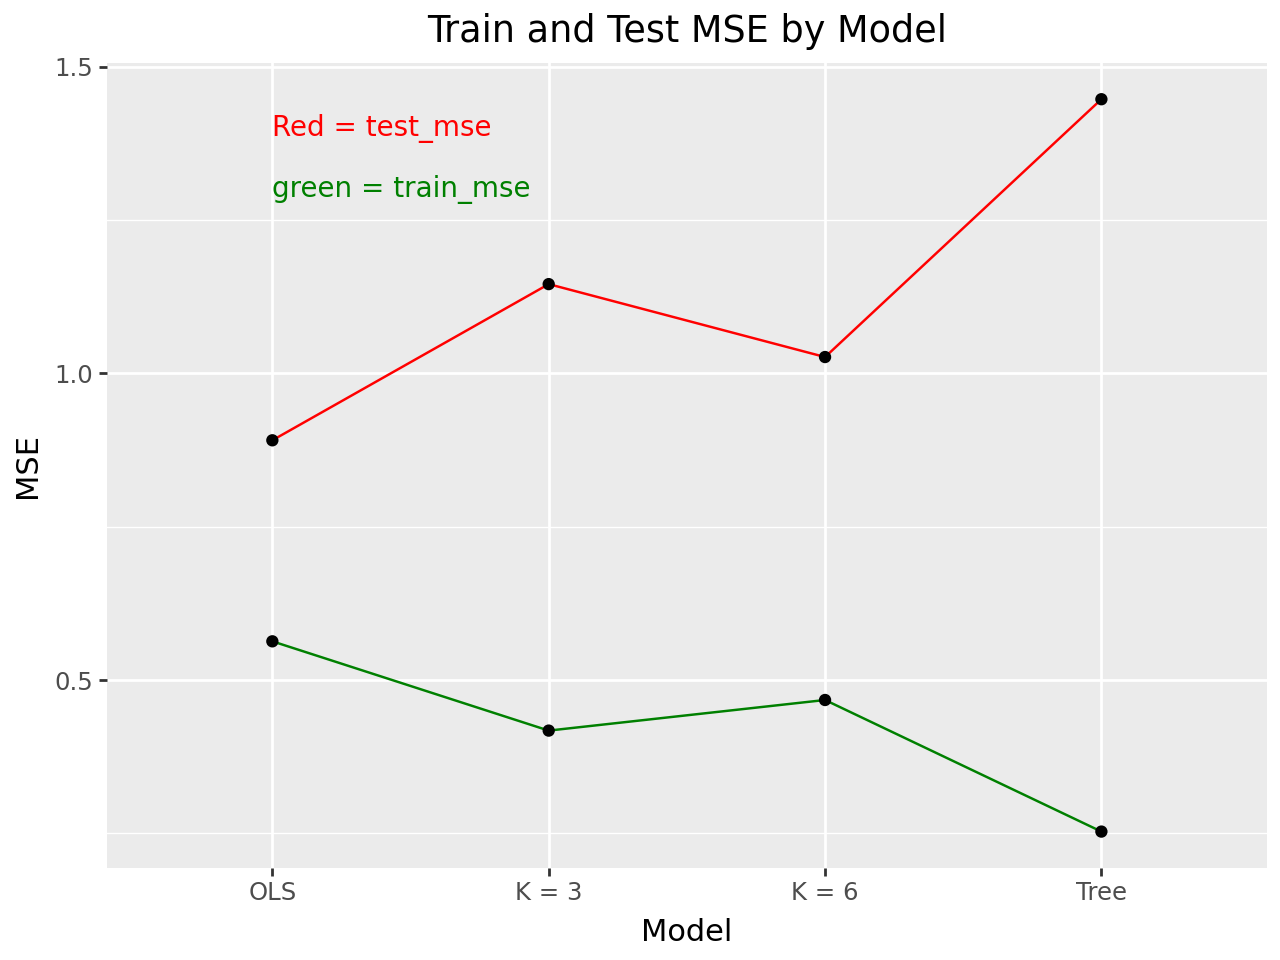

In [108]:
(p9.ggplot(model_selected, p9.aes(x='model',group=1)) +
    p9.geom_line(p9.aes(y='test_mse') ,color = 'red') +
    p9.geom_point(p9.aes(y='test_mse')) +
    p9.geom_line(p9.aes(y='train_mse') ,color = 'green') +
    p9.geom_point(p9.aes(y='train_mse')) +
    p9.labs(x="Model", y="MSE", title="Train and Test MSE by Model") +
    p9.scale_x_discrete(limits=model_selected['model']) +
    p9.scale_color_manual(values={'test_mse': 'red', 'train_mse': 'green'}) +
    p9.annotate("text", x='OLS', y=1.4, label="Red = test_mse", color="red", size=10, ha='left') +
    p9.annotate("text", x='OLS', y=1.3, label="green = train_mse", color="green", size=10, ha='left')
)